<h1>K-Nearest-Neighbor</h1>

In [3]:
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif, RFE, RFECV
from sklearn.metrics import auc, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  

import pickle
from joblib import dump, load


%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

<h2> Understand Data </h2>

In [4]:
#features used to differentiate normal connections from attacks
field_names = pd.read_csv("./Data/Field Names.csv", names=["header", "type"])

added_field_names = pd.DataFrame({"header":["attack", "cnt_correct"],"type":["Nominal", "Count"]})
field_names = field_names.append(added_field_names,sort=False).reset_index().drop("index", axis=1) 

#print data header horizontally for easier viewing
field_names1 = field_names.transpose()
field_names1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
header,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct
type,Numeric,Nominal,Nominal,Nominal,Numeric,Numeric,Binary,Numeric,Numeric,Numeric,Numeric,Binary,Numeric,Binary,Binary,Numeric,Numeric,Numeric,Numeric,Numeric,Binary,Binary,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Nominal,Count


In [5]:
#Combine data file "KDDTrain+.txt" and  header file "Field Names.csv"
data = pd.read_csv("./Data/KDDTrain+.txt", names=field_names["header"])
data.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


<h2> Prepare Training and Test Data </h2>

In [6]:
#Training Data#
X_train_raw = data.drop(['attack', 'cnt_correct'], axis=1)
Y_train_raw = data[['attack']]

In [7]:
#X_train_raw.head()
print("Train Set shape", X_train_raw.shape)

Train Set shape (125973, 41)


In [8]:
#X_train_raw.head()
print("Train Set shape", Y_train_raw.shape)

Train Set shape (125973, 1)


In [9]:
# Process Training set and test set, converting normal connection to 0, attack to 1. 
for i, row in Y_train_raw.iterrows():
    #print(row['category'])
    if row['attack'] == 'normal':
        row['attack'] = 0
    else:
        row['attack'] = 1

Y_train_raw.head()

,attack
0,0
1,0
2,1
3,0
4,0


In [10]:
#Process Test Data 
data_test = pd.read_csv("./Data/KDDTest+.txt", names=field_names["header"])

X_test_raw = data_test.drop(['attack', 'cnt_correct'], axis=1)
Y_test_raw = data_test[['attack']]

for i, row in Y_test_raw.iterrows():
    #print(row['category'])
    if row['attack'] == 'normal':
        row['attack'] = 0
    else:
        row['attack'] = 1
        
Y_test_raw.head()

,attack
0,1
1,1
2,0
3,1
4,1


In [11]:
#print the shape of the datasets
print("XTrain Set shape", X_train_raw.shape)
print("YTrain Set shape", Y_train_raw.shape)
print("XTest Set shape", X_test_raw.shape)
print("YTest Set shape", Y_test_raw.shape)

XTrain Set shape (125973, 41)
YTrain Set shape (125973, 1)
XTest Set shape (22544, 41)
YTest Set shape (22544, 1)


<h2> Apply One Hot Encoding </h2>

In [12]:
#print columns with categorical data 
field_names.loc[field_names['type'] =='Nominal'] ##only 3 symbolic protocol type, service, flag

,header,type
1,protocol_type,Nominal
2,service,Nominal
3,flag,Nominal
41,attack,Nominal


In [13]:
cat_columns = ["protocol_type", "service","flag"]

X_train = pd.get_dummies(X_train_raw, prefix_sep="__",
                              columns=cat_columns)

X_test = pd.get_dummies(X_test_raw, prefix_sep="__",
                              columns=cat_columns)

In [14]:
print("XTrain Set shape:", X_train.shape)
print("XTest Set shape:", X_test.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 116)


In [15]:
# Get missing columns in the training test
missing_cols = set(X_train.columns ) - set(X_test.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]

In [16]:
print("XTrain Set shape:", X_train.shape)
print("XTest Set shape:", X_test.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 122)


In [17]:
X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [18]:
X_test.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [19]:
y_train = Y_train_raw.astype('int')
y_test = Y_test_raw.astype('int')

<h2> Apply KNN Without Any Data Processing </h2>

In [18]:
test_scores = []
train_scores = []

for i in range(1,10):
    print("Processing item: %s" %(i))
    
    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train.values.ravel())
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

Processing item: 1
Processing item: 2
Processing item: 3
Processing item: 4
Processing item: 5
Processing item: 6
Processing item: 7
Processing item: 8
Processing item: 9


In [19]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 99.9944432537131 % and k = [1]


In [20]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 77.20014194464159 % and k = [9]


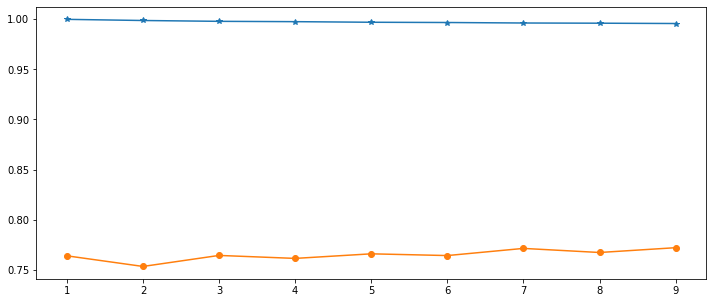

In [21]:
#K-NN Result Visualisation

plt.figure(figsize=(12,5))
plt.plot(range(1,10),train_scores,marker='*',label='Train Score')
plt.plot(range(1,10),test_scores,marker='o',label='Test Score')

In [56]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(9)

knn.fit(X_train,y_train.values.ravel())
knn.score(X_test,y_test.values.ravel())

0.7720014194464159

In [65]:
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test).astype('int')
confusion_matrix(y_test,y_pred)

array([[9431,  280],
       [4860, 7973]], dtype=int64)

In [74]:
pd.crosstab(y_test.values.ravel(), y_pred,rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,9431,280,9711
1,4860,7973,12833
All,14291,8253,22544


In [75]:
#import classification_report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.66      0.97      0.79      9711
          1       0.97      0.62      0.76     12833

avg / total       0.83      0.77      0.77     22544



<h2> Normalization </h2>

In [20]:
X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
#check for any empty fields
X_train.isnull().values.any()
#check for any empty fields
#np.isnan(X_train).any()

False

In [22]:
#test test data for infinite value
np.all(np.isfinite(X_train))
#np.isfinite(X_train).any()

True

In [23]:
# Replace the following columns with the log of themselves 
'''If you have variables that always get positive numbers, such as lenght, weight, etc., and that showes 
much more variation with higher values (heteroscedasticity), a log-normal distribution (i.e., normal after 
log-transformation) might be a clearly better description of the data than a normal distribution.
Log-transforming that kind of variables makes the distributions more normally distributed, stabilizes the variances, 
but also makes your model multiplative on the raw scale instead of additive. '''

log_cols = ["duration", "src_bytes", "dst_bytes", "hot", "num_failed_logins", "num_compromised", "num_root", "num_file_creations", 
            "num_shells", "num_access_files"]

dataframe = X_train

for log_col in log_cols:
    if log_col in dataframe.columns:
        print("Processing column: %s" %(log_col))
        dataframe[log_col] = dataframe[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

Processing column: duration


C:\Users\meiro\.conda\envs\prmls\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


Processing column: src_bytes
Processing column: dst_bytes
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files


In [24]:
#Normalize columns with numeric data (binary data is not normalized)
numeric_cols = list(field_names["header"][field_names["type"] == "Numeric"])
numeric_cols.remove("num_outbound_cmds")
print(numeric_cols)

['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [25]:
#normalize these columns
#https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
X_train_norm = dataframe

norm_type = "mean-std"

for numeric_col in numeric_cols:
    print("Processing column: %s" %(numeric_col))
    tr_values = X_train_norm[numeric_col]
    
    if norm_type == "min-max":
        X_train_norm[numeric_col] = (tr_values - np.min(tr_values))/(np.max(tr_values) - np.min(tr_values))
        X_train_norm[numeric_col] = X_train_norm[numeric_col].astype("float64")
    elif norm_type == "mean-std":
        X_train_norm[numeric_col] = (tr_values - np.min(tr_values))/np.std(tr_values)
        X_train_norm[numeric_col] = X_train_norm[numeric_col].astype("float64")
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: wrong_fragment
Processing column: urgent
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files
Processing column: count
Processing column: srv_count
Processing column: serror_rate
Processing column: srv_serror_rate
Processing column: rerror_rate
Processing column: srv_rerror_rate
Processing column: same_srv_rate
Processing column: diff_srv_rate
Processing column: srv_diff_host_rate
Processing column: dst_host_count
Processing column: dst_host_srv_count
Processing column: dst_host_same_srv_rate
Processing column: dst_host_diff_srv_rate
Processing column: dst_host_same_src_port_rate
Processing column: dst_host_srv_diff_host_rate
Processing column: dst_host_serror_rate
Processing column: dst_host_srv_serror_rate
Pro

In [26]:
X_train_norm.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0.0,2.068858,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.017466,0.027535,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.000000,1.512008,0.225831,0.378663,0.158796,0.550169,0.000000,0.000000,0.000000,0.163102,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,1.663918,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.113529,0.013767,0.000000,0.000000,0.0,0.0,0.181975,0.831884,0.000000,2.570414,0.009033,0.000000,3.175930,2.847934,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.074159,0.082604,2.239873,2.237033,0.0,0.0,0.113734,0.388212,0.000000,2.570414,0.234864,0.222743,0.264661,0.000000,0.000000,2.248291,2.243826,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.0,1.818547,2.537965,0,0.0,0.0,0.0,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.043665,0.068837,0.447975,0.447407,0.0,0.0,2.274686,0.000000,0.000000,0.302402,2.303475,2.227432,0.000000,0.097089,0.355355,0.067449,0.022438,0.000000,0.031303,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,1.767319,1.702167,0,0.0,0.0,0.0,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.261990,0.440556,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.346381,2.570414,2.303475,2.227432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [27]:
#check for any empty fields
X_test.isnull().values.any()
#check for any empty fields
#np.isnan(X_train).any()

False

In [28]:
#test test data for infinite value
np.all(np.isfinite(X_test))

True

In [29]:
# Replace the following columns with the log of themselves because they have very big range
dataframe_test = X_test

for log_col in log_cols:
    if log_col in dataframe_test.columns:
        print("Processing column: %s" %(log_col))
        dataframe_test[log_col] = dataframe_test[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: hot


C:\Users\meiro\.conda\envs\prmls\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files


In [30]:
#normalize these columns
#https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
X_test_norm = dataframe_test

#normalisation
for numeric_col in numeric_cols:
    print("Processing column: %s" %(numeric_col))
    values_test = X_test_norm[numeric_col]
    
    if norm_type == "min-max":
        X_test_norm[numeric_col] = (values_test - np.min(values_test))/(np.max(values_test) - np.min(values_test))
        X_test_norm[numeric_col] = X_test_norm[numeric_col].astype("float64")
    elif norm_type == "mean-std":
        X_test_norm[numeric_col] = (values_test - np.min(values_test))/np.std(values_test)
        X_test_norm[numeric_col] = X_test_norm[numeric_col].astype("float64")
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: wrong_fragment
Processing column: urgent
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files
Processing column: count
Processing column: srv_count
Processing column: serror_rate
Processing column: srv_serror_rate
Processing column: rerror_rate
Processing column: srv_rerror_rate
Processing column: same_srv_rate
Processing column: diff_srv_rate
Processing column: srv_diff_host_rate
Processing column: dst_host_count
Processing column: dst_host_srv_count
Processing column: dst_host_same_srv_rate
Processing column: dst_host_diff_srv_rate
Processing column: dst_host_same_src_port_rate
Processing column: dst_host_srv_diff_host_rate
Processing column: dst_host_serror_rate
Processing column: dst_host_srv_serror_rate
Pro

In [31]:
X_test_norm.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.781597,0.112283,0.0,0.000000,2.40322,2.402658,0.096973,0.231542,0.000000,2.711797,0.089460,0.091811,0.271848,0.000000,0.000000,0.0,0.0,2.582510,2.494599,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.058066,0.011228,0.0,0.000000,2.40322,2.402658,0.024243,0.231542,0.000000,2.711797,0.008946,0.000000,0.271848,0.000000,0.000000,0.0,0.0,2.582510,2.494599,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.358104,2.982939,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.011228,0.0,0.000000,0.00000,0.000000,2.424320,0.000000,0.000000,1.425023,0.769358,1.400115,0.181232,1.991762,0.234214,0.0,0.0,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.000000,0.943481,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.729840,0.0,0.000000,0.00000,0.000000,2.424320,0.000000,3.944156,0.031903,0.509923,2.295271,0.000000,3.265184,3.278996,0.0,0.0,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.000000,0.000000,0.788089,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.089827,0.0,0.402246,2.40322,1.201329,2.424320,0.000000,2.958117,0.308400,0.769358,0.711534,0.770235,0.097956,0.234214,0.0,0.0,2.143483,1.771165,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [32]:
print("XTrain Set shape:",X_train_norm.shape)
print("XTest Set shape:", X_test_norm.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 122)


In [33]:
#check for any empty fields
X_train_norm.isnull().values.any()
#check for any empty fields
#np.isnan(X_train).any()

False

In [34]:
#test train data for infinite value
np.all(np.isfinite(X_train_norm))
#np.isfinite(X_train).any()

True

In [35]:
#check for any empty fields
X_test_norm.isnull().values.any()
#check for any empty fields
#np.isnan(X_train).any()

False

In [36]:
#test train data for infinite value
np.all(np.isfinite(X_test_norm))
#np.isfinite(X_train).any()

True

<h2> Apply KNN After Data Normalisation </h2>

In [74]:
#Setup a knn classifier with k neighbors
knn_norm = KNeighborsClassifier(9)

knn_norm.fit(X_train_norm,y_train.values.ravel())
knn_norm.score(X_test_norm,y_test.values.ravel())

0.7802075940383251

In [75]:
#let us get the predictions using the classifier we had fit above
y_pred_norm = knn_norm.predict(X_test_norm)
confusion_matrix(y_test,y_pred_norm)

array([[9441,  270],
       [4685, 8148]], dtype=int64)

In [76]:
pd.crosstab(y_test.values.ravel(), y_pred_norm, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,9441,270,9711
1,4685,8148,12833
All,14126,8418,22544


In [77]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test.values.ravel(),y_pred_norm))

             precision    recall  f1-score   support

          0       0.67      0.97      0.79      9711
          1       0.97      0.63      0.77     12833

avg / total       0.84      0.78      0.78     22544



<h2> Apply Variance Thresholding </h2>

In [78]:
# Create VarianceThreshold object with a variance with a threshold of 0.5
thresholder = VarianceThreshold(threshold=.90)

# Conduct variance thresholding
X_train_var = thresholder.fit_transform(X_train_norm)
X_test_var = thresholder.fit_transform(X_test_norm)

In [79]:
print("XTrain Set shape:",X_train_var.shape)
print("XTest Set shape:", X_test_var.shape)

XTrain Set shape: (125973, 31)
XTest Set shape: (22544, 31)


<h2> Apply KNN After Variance Thresholding </h2>

In [80]:
#Setup a knn classifier with k neighbors
knn_var = KNeighborsClassifier(9)

knn_var.fit(X_train_var,y_train.values.ravel())
knn_var.score(X_test_var,y_test.values.ravel())

0.7759936124911284

In [81]:
#let us get the predictions using the classifier we had fit above
y_pred_var = knn_var.predict(X_test_var)
confusion_matrix(y_test,y_pred_var)

array([[9458,  253],
       [4797, 8036]], dtype=int64)

In [83]:
#import classification_report
print(classification_report(y_test.values.ravel(),y_pred_var))

             precision    recall  f1-score   support

          0       0.66      0.97      0.79      9711
          1       0.97      0.63      0.76     12833

avg / total       0.84      0.78      0.77     22544



<h2> Apply F-Test </h2>

In [91]:
#Set how floating-point errors are handled.
np.seterr(divide='ignore', invalid='ignore');

In [92]:
selector = SelectPercentile(f_classif, percentile=10)
selector = selector.fit(X_train_norm, y_train.values.ravel())

C:\Users\meiro\.conda\envs\prmls\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [16] are constant.
  UserWarning)


In [93]:
X_train_f = list(X_train_norm.columns[selector.get_support(indices=True)])
X_train_f 

C:\Users\meiro\.conda\envs\prmls\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'flag__S0',
 'flag__SF']

<h2> Apply Decision Tree After F-test </h2>

In [97]:
#Setup a knn classifier with k neighbors
knn_f = KNeighborsClassifier(9)
knn_f.fit(X_train_norm[X_train_f], y_train.values.ravel())
print("Accuracy on normalized training set: {:.3f}".format(knn_f.score(X_train_norm[X_train_f], y_train)))
print("Accuracy on normalized test set: {:.3f}".format(knn_f.score(X_test_norm[X_train_f], y_test)))

Accuracy on normalized training set: 0.997
Accuracy on normalized test set: 0.785


In [98]:
#fit the data
y_pred_f = knn_f.predict(X_test_norm[X_train_f])

In [99]:
#print report
print(confusion_matrix(y_test, y_pred_f))  
print(classification_report(y_test, y_pred_f))

[[9412  299]
 [4541 8292]]
             precision    recall  f1-score   support

          0       0.67      0.97      0.80      9711
          1       0.97      0.65      0.77     12833

avg / total       0.84      0.79      0.78     22544



<h2> Apply Decision Tree with PCA </h2>

In [103]:
pca = PCA(.95)

In [104]:
pca.fit(X_train_norm)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [106]:
knn_pca = KNeighborsClassifier(9)
knn_pca.fit(X_train_pca, y_train.values.ravel())
print("Accuracy on training set: {:.3f}".format(knn_pca.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.3f}".format(knn_pca.score(X_test_pca, y_test)))

Accuracy on training set: 0.997
Accuracy on test set: 0.773


In [107]:
#predict the data
y_pred_pca = knn_pca.predict(X_test_pca)

In [108]:
#print report
print(confusion_matrix(y_test, y_pred_pca))  
print(classification_report(y_test, y_pred_pca))

[[9472  239]
 [4889 7944]]
             precision    recall  f1-score   support

          0       0.66      0.98      0.79      9711
          1       0.97      0.62      0.76     12833

avg / total       0.84      0.77      0.77     22544



<h2> Hyperparameter Tuning </h2>

In [37]:
def train_KNN(X_train, Y_train, grid_search=False):
    
    cv_val = 3
    vb_lvl = 10
    
    params = {'n_neighbors':[3,5],
              'weights':['uniform','distance'],
              'algorithm': ['auto'],
              'p':[1,2]}
    
    if grid_search:
        search_clf = GridSearchCV(KNeighborsClassifier(), params, cv=cv_val, verbose=vb_lvl)
        
        #Learning
        search_clf.fit(X_train, Y_train)

        #The best hyper parameters set
        print("Best Hyper Parameters:", search_clf.best_params_)
        print('Best Score: ', search_clf.best_score_)
        
        best_n_neighbors = search_clf.best_params_["n_neighbors"]
        best_weights = search_clf.best_params_["weights"]
        best_algorithm = search_clf.best_params_["algorithm"]
        best_p = search_clf.best_params_["p"]
        
        clf = KNeighborsClassifier(n_neighbors=best_n_neighbors, 
                                     weights=best_weights,
                                     algorithm=best_algorithm, 
                                     p=best_p,
                                     n_jobs=-1)
        trained_clf = clf.fit(X_train, Y_train)
    else:
        clf = KNeighborsClassifier(algorithm='auto', weights='distance', n_neighbors=3, n_jobs=-1)
        trained_clf = clf.fit(X_train, Y_train)
    
    return trained_clf

In [ ]:
knn_clf = train_KNN(X_train_norm, y_train.values.ravel(), True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] algorithm=auto, n_neighbors=3, p=1, weights=uniform .............
[CV]  algorithm=auto, n_neighbors=3, p=1, weights=uniform, score=0.9981663173937892, total= 7.9min
[CV] algorithm=auto, n_neighbors=3, p=1, weights=uniform .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 20.7min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=1, weights=uniform, score=0.9978804982019956, total= 7.8min
[CV] algorithm=auto, n_neighbors=3, p=1, weights=uniform .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 43.1min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=1, weights=uniform, score=0.9983805668016195, total= 6.7min
[CV] algorithm=auto, n_neighbors=3, p=1, weights=distance ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 62.3min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=1, weights=distance, score=0.9984520861116403, total= 6.7min
[CV] algorithm=auto, n_neighbors=3, p=1, weights=distance ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 81.5min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=1, weights=distance, score=0.9982615322330975, total= 6.7min
[CV] algorithm=auto, n_neighbors=3, p=1, weights=distance ............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 100.6min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=1, weights=distance, score=0.9985472731602762, total= 6.7min
[CV] algorithm=auto, n_neighbors=3, p=2, weights=uniform .............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 119.8min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=2, weights=uniform, score=0.9976185940179082, total= 7.6min
[CV] algorithm=auto, n_neighbors=3, p=2, weights=uniform .............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 141.3min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=2, weights=uniform, score=0.9973803910361744, total= 7.4min
[CV] algorithm=auto, n_neighbors=3, p=2, weights=uniform .............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 162.7min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=2, weights=uniform, score=0.9979280781138367, total= 7.4min
[CV] algorithm=auto, n_neighbors=3, p=2, weights=distance ............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 184.1min remaining:    0.0s


[CV]  algorithm=auto, n_neighbors=3, p=2, weights=distance, score=0.9978329205562965, total= 7.4min
[CV] algorithm=auto, n_neighbors=3, p=2, weights=distance ............
[CV]  algorithm=auto, n_neighbors=3, p=2, weights=distance, score=0.9976661665595008, total= 7.4min
[CV] algorithm=auto, n_neighbors=3, p=2, weights=distance ............
[CV]  algorithm=auto, n_neighbors=3, p=2, weights=distance, score=0.9981424148606811, total= 7.4min
[CV] algorithm=auto, n_neighbors=5, p=1, weights=uniform .............
[CV]  algorithm=auto, n_neighbors=5, p=1, weights=uniform, score=0.9979996189750429, total= 6.8min
[CV] algorithm=auto, n_neighbors=5, p=1, weights=uniform .............
[CV]  algorithm=auto, n_neighbors=5, p=1, weights=uniform, score=0.997642351932557, total= 6.8min
[CV] algorithm=auto, n_neighbors=5, p=1, weights=uniform .............
[CV]  algorithm=auto, n_neighbors=5, p=1, weights=uniform, score=0.9979518933079304, total= 6.8min
[CV] algorithm=auto, n_neighbors=5, p=1, weights=

In [ ]:
y_pred_grid = trained_clf.predict(X_test_norm)

In [ ]:
#print report
print(confusion_matrix(y_test, y_pred_grid))  
print(classification_report(y_test, y_pred_grid))

In [ ]:
from sklearn import metrics

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test,  y_pred)
auc1 = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr1,tpr1,label="KNN without process, auc="+str(auc1))
plt.plot([0,2],[0,2],'k--')

fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test,  y_pred_norm)
auc2 = metrics.roc_auc_score(y_test, y_pred_norm)
plt.plot(fpr2,tpr2,label="KNN after normalisation, auc="+str(auc1))
plt.plot([0,2],[0,2],'k--')

fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test,y_pred_var)
auc3 = metrics.roc_auc_score(y_test, y_pred_var)
plt.plot(fpr3,tpr3,label="KNN after Variance Thresholding, auc="+str(auc3))
plt.plot([0,2],[0,2],'k--')

fpr4, tpr4, thresholds4 = metrics.roc_curve(y_test,  y_pred_f)
auc4 = metrics.roc_auc_score(y_test, y_pred_f)
plt.plot(fpr4,tpr4,label="KNN after F-test, auc="+str(auc4))
plt.plot([0,2],[0,2],'k--')

fpr6, tpr6, thresholds6 = metrics.roc_curve(y_test,  y_pred_pca)
auc6 = metrics.roc_auc_score(y_test, y_pred_rfe)
plt.plot(fpr6,tpr6,label="KNN after PCA, auc="+str(auc6))
plt.plot([0,2],[0,2],'k--')

fpr7, tpr7, thresholds7 = metrics.roc_curve(y_test,  y_pred_grid)
auc7 = metrics.roc_auc_score(y_test, y_pred_grid)
plt.plot(fpr7,tpr7,label="KNN after Grid Search, auc="+str(auc7))
plt.plot([0,2],[0,2],'k--')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title(' ROC curve')

plt.legend(loc=2)
plt.show()
